# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Data has been gathered from different types of job listings. We have 3 different databases: 
- train_features, where each row represents metadata for an individual job posting
- train_salaries, where the job ID matches the one in train_features and assigns it a salary
- test_features, similar to train_features, we are going to use it to test our model

The goal of this project is to use all the data we have to most accuretely predict the salary for the job descriptions in the test_features as well as generally predict salary for all types of job descriptions in the real world.

In [766]:
__author__ = "Said Mrad"
__email__ = "saidmrad98@gmail.com"

In [767]:
#import libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [768]:
import pandas.util.testing as tm
import xgboost as xgb

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [769]:
#load the data into a Pandas dataframe
filepath = 'data/train_features.csv'
filepath1 = 'data/train_salaries.csv'
filepath2 = 'data/test_features.csv'
df_raw_train_feature = pd.read_csv(filepath)
df_raw_train_salaries = pd.read_csv(filepath1)
df_raw_test_feature = pd.read_csv(filepath2)

#### Examine Data

Examine the first 3 rows of each dataset to get a genreal overview of the training features provided. 

In [770]:
df_raw_train_feature.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38


For each job posting, we also get the position ID, the job type, the minimum degree required (can be NONE), the major required, the industry, years of experience and miles From Metropolis.
We can already observe that job descriptions that require no degree or a high school degree for the degree field will not require a specific major which makes sense.

To observe salary we theorize that all of these features would be able to influence that variable with probably more emphasis on some specific ones like years of experience or job type.

In [771]:
df_raw_train_salaries.head(3)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137


This is the same Job ID as the train features dataset and assigns a salary to it, this means that it would be very easy to merge both tables.

In [772]:
df_raw_test_feature.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9


Similar dataset to the first one we observed however it does not have an accompanying salary dataset, we will try to predict it as we have the same features here as the training data does.

### ---- 3 Clean the data ----

First we check if any of the data is null, we create a new dataset after applying the isnull() function to each of our datasets. If there is a null value it will appear as True

In [773]:
missing_data = df_raw_train_feature.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

companyId
False    1000000
Name: companyId, dtype: int64

jobType
False    1000000
Name: jobType, dtype: int64

degree
False    1000000
Name: degree, dtype: int64

major
False    1000000
Name: major, dtype: int64

industry
False    1000000
Name: industry, dtype: int64

yearsExperience
False    1000000
Name: yearsExperience, dtype: int64

milesFromMetropolis
False    1000000
Name: milesFromMetropolis, dtype: int64



In [774]:
missing_data = df_raw_train_salaries.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

salary
False    1000000
Name: salary, dtype: int64



In [775]:
missing_data1 = df_raw_test_feature.isnull()
for column in missing_data1.columns.values.tolist():
    print(column)
    print (missing_data1[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

companyId
False    1000000
Name: companyId, dtype: int64

jobType
False    1000000
Name: jobType, dtype: int64

degree
False    1000000
Name: degree, dtype: int64

major
False    1000000
Name: major, dtype: int64

industry
False    1000000
Name: industry, dtype: int64

yearsExperience
False    1000000
Name: yearsExperience, dtype: int64

milesFromMetropolis
False    1000000
Name: milesFromMetropolis, dtype: int64



Thus we do not have any null data.

Here we will use the method .info() it will give us, for each datasets, the length of its columns and its data types.

In [776]:
df_raw_train_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


We do not have null data the data types seems to be appropriate. I want to see the amount of unique values for companyID. We have 1,000,000 x 8 for the shape of the datasets as we have 1,000,000 entries and 8 columns

In [777]:
df_raw_train_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


The shape here is 1,000,000 x 2 we do not see any missing values

In [778]:
df_raw_test_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [779]:
df_raw_train_feature["companyId"].describe()

count     1000000
unique         63
top        COMP39
freq        16193
Name: companyId, dtype: object

We only have 63 unique companies, I thought it would be possible that we had 1 000 000 different companies and thus it would have been more appropriate to change it to a company ID and numerical data but we have 63 companies and it seems like they all have around 15-16k listings as if they all had the same number of listings each company would have (1,000,000/ 63 = 15873 listings) 15973 listings and that is not far from our top frequency 

Lets examine the jobId column

In [780]:
df_raw_train_feature["jobId"]

0         JOB1362684407687
1         JOB1362684407688
2         JOB1362684407689
3         JOB1362684407690
4         JOB1362684407691
                ...       
999995    JOB1362685407682
999996    JOB1362685407683
999997    JOB1362685407684
999998    JOB1362685407685
999999    JOB1362685407686
Name: jobId, Length: 1000000, dtype: object

It seems like they are in chronological order. i want to see if I need to **check for duplicate data** I will check out the column's decribe
The Id's start from "JOB1362684407687" and finish at "JOB1362685407686" incrementing by 1 for every new job description

In [781]:
df_raw_train_feature["jobId"].describe()

count              1000000
unique             1000000
top       JOB1362684566745
freq                     1
Name: jobId, dtype: object

1 000 000 unique values which means there are no duplicate job listings in the training dataset, there can be duplicate job description but it would be for different jobs. We confirm this is the case in all datasets by summing up the amount of duplicates found in each dataset with the duplicated() and sum() methods

#### Check for duplicates

In [782]:
df_raw_train_feature.duplicated().sum()

0

In [783]:
df_raw_train_salaries.duplicated().sum()

0

In [784]:
df_raw_test_feature.duplicated().sum()

0

All jobId's are unique so different jobs so no duplicates.

#### Summarize numerical and categorical variables of training and testing features

In [785]:
df_raw_train_feature.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684566745,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [786]:
df_raw_train_feature.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


The categorical values will have the number of unique categories, the most frequent one as well as the frequency in which it is represented. 
We notice by doing some quick math that most categories have around the same number of entries for the categorical data (except for major) (we divide the coount by the amouont of uniques, the top frequency is usually close to the result we find which leads us to give the assumption above (was already explained for companyID).
The numerical data, we have the mean the standard deviation and 5 number summary (min, Q1, median, Q3, max)
We will analyze this further with abalyzing the value counts of each category per categorical data

In [787]:
df_raw_test_feature.describe(include = 'all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN
top,JOB1362685606960,COMP13,VICE_PRESIDENT,HIGH_SCHOOL,NONE,SERVICE,NaN,NaN
freq,1,16130,125434,238255,534068,143161,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,12.002104,49.526414
std,NaN,NaN,NaN,NaN,NaN,NaN,7.213179,28.889713
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000


We notice that the test data is very similar to the training data. For the categorical data we have the same amount of unique categories per categorical data and for the numerical data the mean the standard deviation and the 5 number summary are all very similar

In [788]:
df_raw_train_salaries.describe()

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


We immediately notice something unusual here with the minimum salary being 0, also it seems like their is a skew to the right as the gap between the 3rd quartile and the max is bigger than any other gap. Also the mean is after the median but slighlty so there would be a very slight skew if anything
We are going to probably remove some outliers in the salary. Since the salaries dataset shares a common unique identifier in JobId with the training features dataset we will merge them so that the jobId's we remove from one will be removed from the other.
Also it is best practice before applying a model to it that the training and target (salary) variables are in the same dataset

In [789]:
#Merge features and the target and examine the first 3 rows of new dataframe
df_train = pd.merge(df_raw_train_feature, df_raw_train_salaries, on='jobId')
df_train.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137


We now have our complete training dataset with all the feature variables as well as our target which is salary. We make sure that all our data is there as well that all the columns data types are intact

In [790]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


#### We now want to find potential outliers in our target variable - salaries

In [791]:
salary_info = df_train.salary.describe()
salary_info

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

As we pointed out above, we have some irregularities as we find jobs with 0 salary. We will use the IQR rule to find potential outliers - IQR = Q3-Q1, the upper bound is 1.5 * IQR + Q3 and the lower bound Q1 - 1.5 * IQR 

In [792]:
IQR = salary_info["75%"] - salary_info["25%"]
upper_bound = salary_info["75%"] + 1.5 * IQR
lower_bound = salary_info["25%"] - 1.5 * IQR
print("The upper and lower bounds for suspected outliers are", lower_bound, "and", upper_bound)


The upper and lower bounds for suspected outliers are 8.5 and 220.5


#### Examine outliers

In [793]:
df_train.loc[df_train.salary < 8.5, "salary"].value_counts()

0    5
Name: salary, dtype: int64

There are a total of 5 outliers under the lower bound all of 0, lets investigate them further

In [794]:
# check potential outlier below lower bound
df_train[df_train.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


All the entries below the lower bound are oof 0 salary and they do not appear to be volunteer positions. These are all very likely missing or corrupt data and we are going to remove them from the training set.
Looking at the 5 number summary for salary, we can say that its distribution will likely have a right skew, thus we assume that the count of upper bound outlier will be big. We will the upper bound outliers by jobType as better job type usually earn more salary.

In [795]:
df_train.loc[df_train.salary > 222.5, 'jobType'].value_counts()

CEO               2893
CFO               1308
CTO               1298
VICE_PRESIDENT     520
MANAGER            188
SENIOR              50
JUNIOR              16
Name: jobType, dtype: int64

Better job type do yield a better salary. We will take a closer look at the Junior category as it would be the lleast likely to earn more than the upper bound.

In [796]:
# Check most suspicious potential outliers above upper bound
df_train[(df_train.salary > 222.5) & (df_train.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


There does not seem to be outliers on the upperbound as all the job description seeking Juniors paying salaries higher than the upper bound are all in high paying industries "Finance", "Oil" with high earning majors "Engineering", "Business" as well high earning degrees "Masters" "Doctoral".

Thus we will only remove the salaries under the lower bound which are all at 0.

In [797]:
df_train = df_train[df_train.salary > 8.5]
df_train

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


We notice that we now have 999,995 rows as we deleted the 5 columns with 0 salary
we want to reset the index and then our database will be cleaned

In [798]:
df_train = df_train.reset_index() #reset index after deleting multiple rows
df_train = df_train.drop(df_train.columns[0], axis = 'columns') #delete index columns dans comes from resetting index
df_train

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
...,...,...,...,...,...,...,...,...,...
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


### ---- 4 Explore the data (EDA) ----

We will have another describe to see the types of the categories too (can also be optained with df_train.dtypes())

In [799]:
df_train.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [800]:
df_train.describe(include = 'O')

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684566745,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


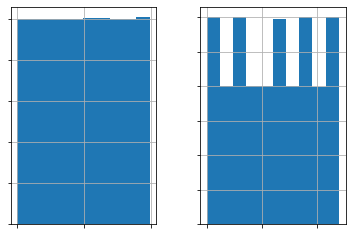

In [801]:
#Analyze numerical features individually
viz = df_train[['yearsExperience','milesFromMetropolis']]
viz.hist()
plt.show()

For our two numerical features, we notice first at milesFromMetropolis, binned by 10s, that their are as many job descriptions 100k for all the bins from the metropolis while yearExperidnce in bins of 2 ranges from 120k to 80k per bin for each one.
We will now look at the frequency tables for some of our category variables - jobType, degree, major, industry as company ID as to many unique values

In [802]:
#Analyze categeroical features individually
#jobtype
jobType_counts = df_train['jobType'].value_counts().to_frame()
jobType_counts.rename(columns={'jobType': 'value_counts'}, inplace=True)
jobType_counts.index.name = 'jobType'
jobType_counts

,value_counts
jobType,
SENIOR,125886
VICE_PRESIDENT,125234
MANAGER,125120
CTO,125045
JANITOR,124971
CEO,124778
JUNIOR,124592
CFO,124369


In [803]:
#Analyze categeroical features individually
#degree
degree_counts = df_train['degree'].value_counts().to_frame()
degree_counts.rename(columns={'degree': 'value_counts'}, inplace=True)
degree_counts.index.name = 'degree'
degree_counts

,value_counts
degree,
HIGH_SCHOOL,236975
NONE,236853
BACHELORS,175495
DOCTORAL,175362
MASTERS,175310


In [804]:
#Analyze categeroical features individually
#major
major_counts = df_train['major'].value_counts().to_frame()
major_counts.rename(columns={'major': 'value_counts'}, inplace=True)
major_counts.index.name = 'major'
major_counts

,value_counts
major,
NONE,532353
CHEMISTRY,58875
LITERATURE,58684
ENGINEERING,58594
BUSINESS,58518
PHYSICS,58410
COMPSCI,58382
BIOLOGY,58379
MATH,57800


In [805]:
industry_counts = df_train['industry'].value_counts().to_frame()
industry_counts.rename(columns={'industry': 'value_counts'}, inplace=True)
industry_counts.index.name = 'industry'
industry_counts

,value_counts
industry,
WEB,143205
AUTO,142941
FINANCE,142866
EDUCATION,142819
OIL,142770
HEALTH,142755
SERVICE,142639


As previously theorized, categories for our categorical features have around the same value_counts by category for job types around 125k job descriptions per. It is the same for the industry as we have around 143k job describtion per industry. 
For the other two categories there are some differences but most of the counts are the same per category and will create different groups (the degree category, one group has no degree or only a high school degree requirements(232k each while the other group requires you at minimum to go to college (175k each) -  the first group will not require a major as a result as well for the major requirement and thus that specific category is higher than the other majors that are all at 50k job descriptions per.

#### Visualize target variable - salary

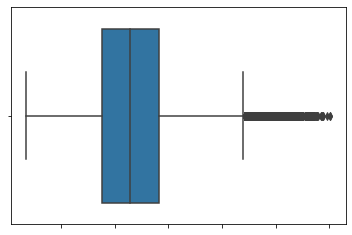

In [806]:
sns.boxplot(df_train.salary)

We can see we that we got rid of all our outliers under the lower bound and we theorize a right skew with the data seeming to elongate to the right

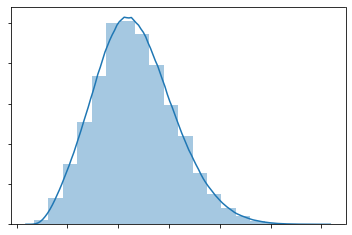

In [807]:
sns.distplot(df_train.salary, bins=20)

There is a slight right skew

#### Analyze feature variable with target variable

First numerical variables, i want to see hoow the variables intereact with the target variable, we will then get pearsons correlation for both of them. Since they are continuous integers over a range and it is a massive database instead of doing a scatterplot and fit a line through it, i will be plotting their means  and fit a line through that as well as their standars deviations which will be filled in.

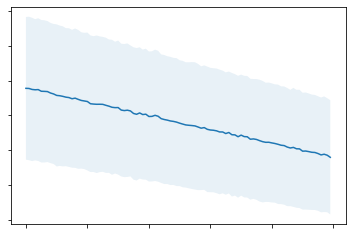

In [808]:
mean = df_train.groupby("milesFromMetropolis")['salary'].mean()
std = df_train.groupby("milesFromMetropolis")['salary'].std()
mean.plot()
plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                 alpha = 0.1)
plt.xticks(rotation=45)
plt.ylabel('Salaries')
plt.show()

It seems like it is a moderate/ weak negative correlation. Let's see what the Pearson coefficient is as well as the p-value to see if that correlation is statistically siginificant.

In [809]:
pearson_coef, p_value = stats.pearsonr(df_train['milesFromMetropolis'], df_train['salary'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.29768642704964454  with a P-value of P = 0.0


Since the p-value is < 0.001, the correlation between milesFromMetropolis and salary is statistically significant, although the linear relationship isn't extremely strong (~-0.297)

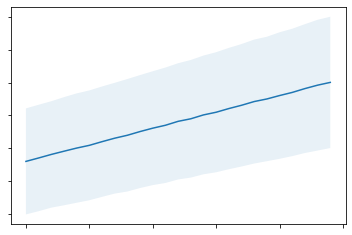

In [810]:
mean = df_train.groupby('yearsExperience')['salary'].mean()
std = df_train.groupby('yearsExperience')['salary'].std()
mean.plot()
plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
plt.xticks(rotation=45)
plt.ylabel('Salaries')
plt.show()

It seems like it is a positive correlation. 

In [811]:
pearson_coef, p_value = stats.pearsonr(df_train['yearsExperience'], df_train['salary'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.37501340199972  with a P-value of P = 0.0


Since the p-value is < 0.001, the correlation between yearsExperience and salary is statistically significant, although the linear relationship isn't extremely strong (~0.375)

We now do the same for companyId as it has too many unique categories to be observed by category 


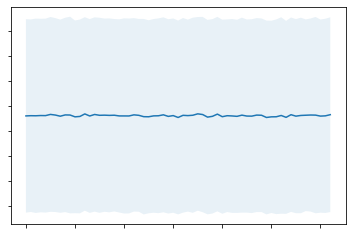

In [812]:
mean = df_train.groupby('companyId')['salary'].mean()
std = df_train.groupby('companyId')['salary'].std()
mean.plot()
plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
plt.xticks(rotation=45)
plt.ylabel('Salaries')
plt.show()

In [813]:
mean

companyId
COMP0     115.963615
COMP1     116.048609
COMP10    116.019800
COMP11    116.113029
COMP12    116.086485
             ...    
COMP61    116.318607
COMP62    116.279872
COMP7     115.888501
COMP8     115.989641
COMP9     116.453340
Name: salary, Length: 63, dtype: float64

It does noot seem to be statistically significant if we look at the means they are all similar so we assume there is a very weak correlation between companyID and salary.

We can do an analysis of Variance (ANOVA) to confirm that more, since we have 63 unique values doing it with 10 will still yield a statistical significant result

In [814]:
grouped_test=df_train[['companyId', 'salary']].groupby(['companyId'])
grouped_test.head(2)

,companyId,salary
0,COMP37,130
1,COMP19,101
2,COMP52,137
3,COMP38,142
4,COMP7,163
...,...,...
275,COMP35,139
307,COMP60,124
314,COMP10,187
350,COMP60,132


In [815]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_test.get_group('COMP0')['salary'], 
                              grouped_test.get_group('COMP1')['salary'], 
                              grouped_test.get_group('COMP2')['salary'],
                              grouped_test.get_group('COMP3')['salary'],
                              grouped_test.get_group('COMP4')['salary'],
                              grouped_test.get_group('COMP5')['salary'],
                              grouped_test.get_group('COMP6')['salary'],
                              grouped_test.get_group('COMP7')['salary'],
                              grouped_test.get_group('COMP8')['salary'],
                              grouped_test.get_group('COMP9')['salary'] )  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 0.7821696482190108 , P = 0.633004050105283


The F value being so small as well as the p value being that high means that they are not statcally significant

Now we look at the categorical features and compare each category to the target variable salary - jobType, degree, major, industry

### jobType

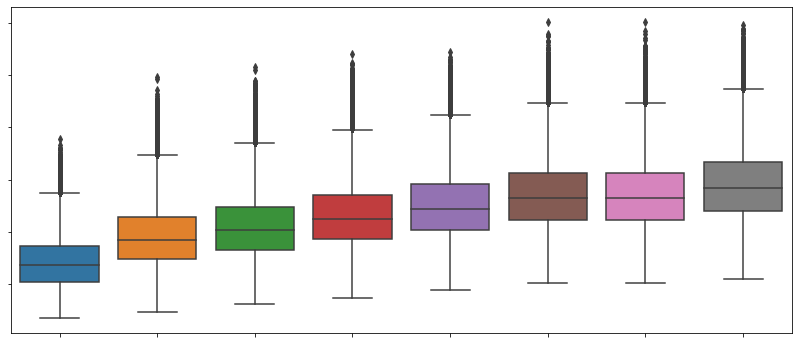

In [816]:

plt.figure(figsize = (14, 6))
mean = df_train.groupby('jobType')['salary'].mean()
df_train['jobType'] = df_train['jobType'].astype('category')
levels = mean.sort_values().index.tolist()
df_train['jobType'].cat.reorder_categories(levels, inplace=True)
sns.boxplot(x = 'jobType', y = 'salary', data=df_train)

JobType clearly influences salary with CFO, CT0 and CEO earning the most, this makes sense as they run the company. There is a clearly a positive relationship between both of them

In [817]:
grouped_test1=df_train[['jobType', 'salary']].groupby(['jobType'])
f_val, p_val = stats.f_oneway(grouped_test1.get_group('JANITOR')['salary'], 
                              grouped_test1.get_group('JUNIOR')['salary'], 
                              grouped_test1.get_group('SENIOR')['salary'],
                              grouped_test1.get_group('MANAGER')['salary'],
                              grouped_test1.get_group('VICE_PRESIDENT')['salary'],
                              grouped_test1.get_group('CFO')['salary'],
                              grouped_test1.get_group('CTO')['salary'],
                              grouped_test1.get_group('CEO')['salary'] )  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 79301.48972207512 , P = 0.0


This is a great result, with a large F test score showing a strong correlation and a P value of 0 implying almost certain statistical significance.

## degree

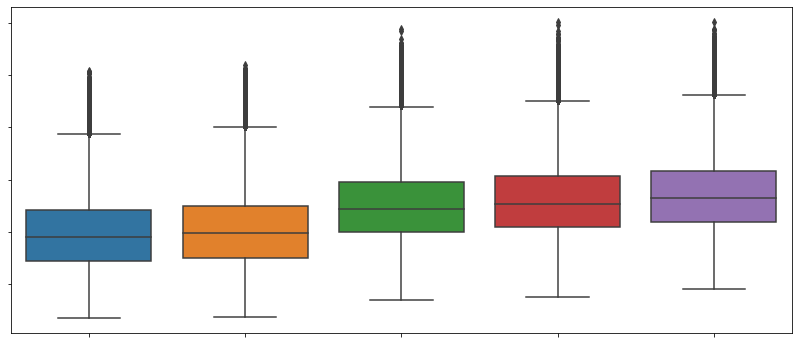

In [818]:
#degree
plt.figure(figsize = (14, 6))
mean = df_train.groupby('degree')['salary'].mean()
df_train['degree'] = df_train['degree'].astype('category')
levels = mean.sort_values().index.tolist()
df_train['degree'].cat.reorder_categories(levels, inplace=True)
sns.boxplot(x = 'degree', y = 'salary', data=df_train)

college degrees tend to correlate to a higher salary

In [819]:
grouped_test2=df_train[['degree', 'salary']].groupby(['degree'])
f_val, p_val = stats.f_oneway(grouped_test2.get_group('NONE')['salary'], 
                              grouped_test2.get_group('HIGH_SCHOOL')['salary'], 
                              grouped_test2.get_group('BACHELORS')['salary'],
                              grouped_test2.get_group('MASTERS')['salary'],
                              grouped_test2.get_group('DOCTORAL')['salary'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 47988.0535384912 , P = 0.0


A large F test score showing a strong correlation and a P value of 0 implying almost certain statistical significance.

## major

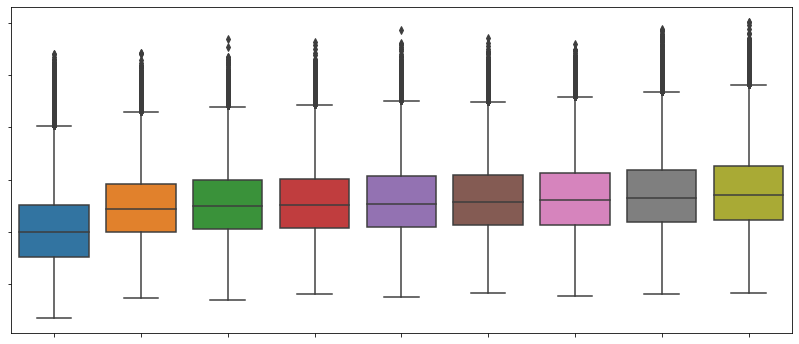

In [820]:
#major
plt.figure(figsize = (14, 6))
mean = df_train.groupby('major')['salary'].mean()
df_train['major'] = df_train['major'].astype('category')
levels = mean.sort_values().index.tolist()
df_train['major'].cat.reorder_categories(levels, inplace=True)
sns.boxplot(x = 'major', y = 'salary', data=df_train)

Engineering, business and math pay better

In [821]:
grouped_test3=df_train[['major', 'salary']].groupby(['major'])
f_val, p_val = stats.f_oneway(grouped_test3.get_group('NONE')['salary'], 
                              grouped_test3.get_group('LITERATURE')['salary'], 
                              grouped_test3.get_group('BIOLOGY')['salary'],
                              grouped_test3.get_group('CHEMISTRY')['salary'],
                              grouped_test3.get_group('PHYSICS')['salary'],
                              grouped_test3.get_group('COMPSCI')['salary'],
                              grouped_test3.get_group('MATH')['salary'],
                              grouped_test3.get_group('BUSINESS')['salary'],
                              grouped_test3.get_group('ENGINEERING')['salary'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 20924.535311417687 , P = 0.0


A large F test score showing a strong correlation and a P value of 0 implying almost certain statistical significance.

## Industry

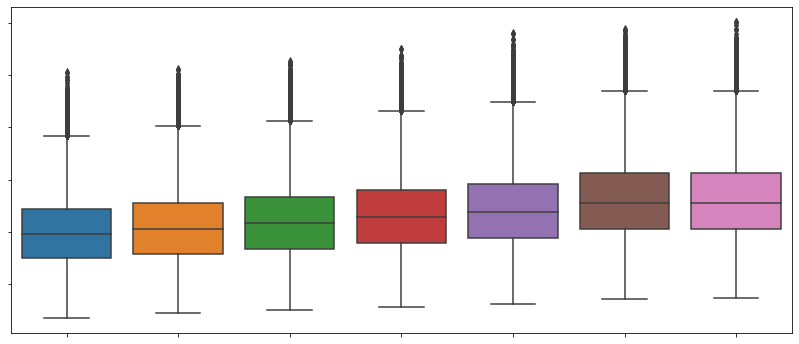

In [822]:
#industry
plt.figure(figsize = (14, 6))
mean = df_train.groupby('industry')['salary'].mean()
df_train['industry'] = df_train['industry'].astype('category')
levels = mean.sort_values().index.tolist()
df_train['industry'].cat.reorder_categories(levels, inplace=True)
sns.boxplot(x = 'industry', y = 'salary', data=df_train)

Industries of oil, finance and web tend to pay better (we did observe that when we were trying to find the corrupt data)

In [823]:
grouped_test4=df_train[['industry', 'salary']].groupby(['industry'])
f_val, p_val = stats.f_oneway(grouped_test4.get_group('EDUCATION')['salary'], 
                              grouped_test4.get_group('SERVICE')['salary'], 
                              grouped_test4.get_group('AUTO')['salary'],
                              grouped_test4.get_group('HEALTH')['salary'],
                              grouped_test4.get_group('WEB')['salary'],
                              grouped_test4.get_group('FINANCE')['salary'],
                              grouped_test4.get_group('OIL')['salary'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 16079.108315731506 , P = 0.0


A large F test score showing a strong correlation and a P value of 0 implying almost certain statistical significance.

We will discard jobId and companyId as a training feature as it is a unique value for each row for the first and we proved that the latter was not statiscally significant. MilesfromMetropolis, WorkExperience, Job_Type, Degree, Major and Industry are going to be our training features and salary our target variable
We now will want to one hot encode the categorical data - we need to be able to see it as numerical data, each category will have a column to do that - even though we observed a very weak relationship between companyID and salary, we want to make sure that our assumptions are correct

In [824]:
def cat_to_num(data):
    # encode the categories using average salary for each category to replace label
    for col in data.columns:
        if data[col].dtype.name == 'category':
            feature_dict = {}
            feature_list = data[col].cat.categories.tolist()
            for ft in feature_list:
                feature_dict[ft] = data[data[col] == ft]['salary'].mean()
            data[col] = data[col].map(feature_dict)
            data[col] = data[col].astype('float64')


In [825]:
df_train1 = df_train.copy()
cat_to_num(df_train1)
df_train1

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,135.458547,130.505647,133.322042,115.735540,10,83,130
1,JOB1362684407688,COMP19,145.311425,101.921085,102.583864,121.645362,3,73,101
2,JOB1362684407689,COMP52,125.368630,135.490979,130.372436,115.735540,10,38,137
3,JOB1362684407690,COMP38,115.368518,135.490979,129.072085,109.435222,8,17,142
4,JOB1362684407691,COMP7,125.368630,125.454663,130.372436,130.747659,8,16,163
...,...,...,...,...,...,...,...,...,...
999990,JOB1362685407682,COMP56,125.368630,125.454663,129.072085,115.735540,19,94,88
999991,JOB1362685407683,COMP24,135.481067,101.921085,102.583864,130.747659,12,35,160
999992,JOB1362685407684,COMP23,95.333087,101.921085,102.583864,99.448386,16,81,64
999993,JOB1362685407685,COMP3,135.458547,130.505647,102.583864,115.735540,6,5,149


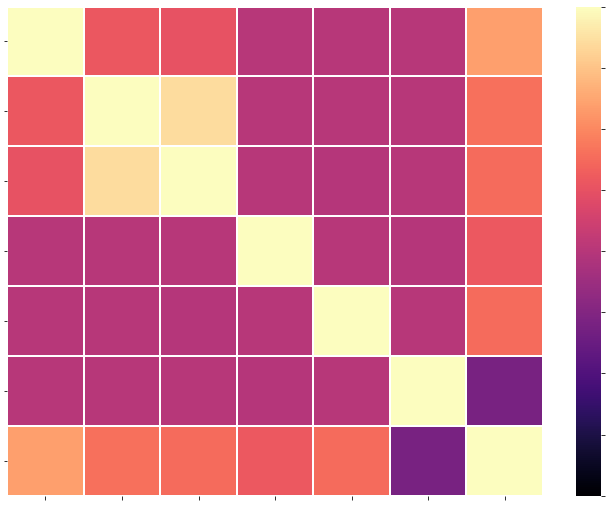

In [826]:
fig = plt.figure(figsize=(12, 9))
features = ['jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(df_train1[features + ['salary']].corr(), cmap='magma',vmin=-1, vmax=1, annot=True, linewidths=1)
plt.title('Heatmap of Correlation Matrix')
plt.xticks(rotation=45)
plt.show()


We see that jobType is most strongly correlated with salary, followed by degree, major, and yearsExperience.

The features also have some correlation, degree and major have a strong correlation while major/degree and jobType have a weak one

### ---- 5 Establish a baseline ----

We are going to evaluate our models using the Mean Squared error which is geared more towards large errors as it squares each error. It is the reasonable metric to select as the problem is a regression one where the numerical, continuous target depends on a set of features.

Before we build our complex models, let's start with a baseline metric. We'll compare our other models to the baseline to show how much they improve over the baseline. A common metric for making salary comparisons is the average job type salary.

In [827]:
df_baseline = df_train.groupby('jobType', as_index = False).mean()
df_baseline.rename(columns = {'salary':'avg_salary'}, inplace = True)
df_baseline = df_baseline[['jobType', 'avg_salary']]
df_baseline

,jobType,avg_salary
0,JANITOR,70.813045
1,JUNIOR,95.333087
2,SENIOR,105.487775
3,MANAGER,115.368518
4,VICE_PRESIDENT,125.368630
5,CFO,135.458547
6,CTO,135.481067
7,CEO,145.311425


In [828]:
df_baseline= pd.merge(df_train, df_baseline, on = 'jobType')
df_baseline.head(3)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,avg_salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,135.458547
1,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178,135.458547
2,JOB1362684407712,COMP27,CFO,BACHELORS,CHEMISTRY,AUTO,9,70,131,135.458547


In [829]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_baseline['salary'], df_baseline['avg_salary']).round(2)

963.93

It is traditional for HR departments to make salary decesions based on the mean of the specific type of job the professional will have. We'll use the MSE of 963 for the average salaries compared to the actually salaries as our baseline. Our goal is to lower the MSE below 360 with at least one of our models so that we have a decrease of 600.

### ---- 6 Hypothesize solution ----

It's understandable that just using the average salary by Job Type is not the most accurate model. Almost all of the features demostrate some kind of predictive behavior, with jobType and degree being strong indicators. CompanyID is the least predictive, and I don't think it would add value to consider it as a factor.

The prediction of our baseline model is based on the data itself without any fitting, feature engineering or tuning, so the result is not ideal. Our goal is to find the best model to beat this baseline model, i.e. get a model with much lower mse score.

We are dealing here with a continuous variable as a target variable (salary) which means that using Regression will be ideal here. We have the labels as well so a Supervised Machine Learning algorithms will be used to improve the prediction results. Regression and Ensembles of Regression Algorithms suit our data and goal of predicting new salaries:
3 models that should improve results over the baseline model given the above EDA, we will want the best one:
- LinearRegression - Sometimes simple is best
- RandomForestRegressor - Improved accuracy and control over-fittings
- GradientBoostingRegressor - Can optimise on Least Squares regression.

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [830]:
df_test = df_raw_test_feature

In [831]:
df_test['jobType'] = df_test['jobType'].astype('category')
df_test['major'] = df_test['major'].astype('category')
df_test['industry'] = df_test['industry'].astype('category')
df_test['degree'] = df_test['degree'].astype('category')

In [832]:
from sklearn.preprocessing import LabelEncoder

In [833]:
class Data:
    def __init__(self, train_file, test_file, categorical_cols, numeric_cols, target_col, key):
        # create new copies instead of references
        self.categorical_cols = list(categorical_cols)
        self.numeric_cols = list(numeric_cols)
        self.feature_cols = categorical_cols + numeric_cols
        self.target_col = target_col
        self.key = key
        self.label_encoders = {}
        self.df_train = self._create_df_train(train_file)
        self.df_test = self._create_df_test(test_file)
        self.df_results = pd.DataFrame(self.df_test)
    
    def label_df_encode(self, df, cols):
        # creates one label encoder (convert object data to numeric data) for each column in the data frame
        for col in cols:
            if col in self.label_encoders:
                # if label encoder already exits for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)

    def _label_encode(self, df, col, le=None):
        # label encodes data
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le

    def _create_df_train(self, df_train):#, label_encode=True):
        # loads and merges training data features and targets, preprocesses data, encodes data
        #if label_encode:
            #self.label_df_encode(df_train, self.categorical_cols)
        #return df_train
        self.label_df_encode(df_train, self.categorical_cols)
        return df_train

    def _create_df_test(self, df_test):#, label_encode=True):
        # loads and label encodes test data
        #df_test = self._load_data(test_file)
        #if label_encode:
            #self.label_df_encode(df_test, self.categorical_cols)
        #return df_test
        self.label_df_encode(df_test, self.categorical_cols)
        return df_test

In [834]:
class FeatureGenerator:
    def __init__(self, data):
        # initializes class and creates groupby object for data
        self.data = data
        # able to generate features for new companies, but less accurate
        self.categorical_cols = data.categorical_cols
        self.groups = data.df_train.groupby(self.categorical_cols)
        
    def add_group_stats(self):
        # adds group statistics to data stored in data object
        # get group stats
        df_group_stats = self._get_group_stats()
        df_group_stats.reset_index(inplace=True)

        # merge derived columns to original df
        self.data.df_train = self._merge_new_cols(self.data.df_train, df_group_stats, self.categorical_cols, fillna=True)
        self.data.df_test = self._merge_new_cols(self.data.df_test, df_group_stats, self.categorical_cols, fillna=True)

        # update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_col_lists(self.data, categorical_cols=group_stats_cols)

    def _get_group_stats(self):
        # calculates group statistics
        target_col = self.data.target_col
        df_group_stats = pd.DataFrame({'group_mean': self.groups[target_col].mean()})
        df_group_stats['group_max'] = self.groups[target_col].max()
        df_group_stats['group_min'] = self.groups[target_col].min()
        df_group_stats['group_std'] = self.groups[target_col].std()
        df_group_stats['group_median'] = self.groups[target_col].median()
        return df_group_stats

    def _merge_new_cols(self, df, df_new_cols, keys, fillna=False):
        # merges engineered features with original df
        df = pd.merge(df, df_new_cols, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df

    def _extend_col_lists(self, data, categorical_cols=[], numeric_cols=[]):
        # addes engineered feature cols to data col lists
        data.numeric_cols.extend(numeric_cols)
        data.categorical_cols.extend(categorical_cols)
        data.feature_cols.extend(numeric_cols + categorical_cols)

"jobID" is unique for each record in the data, thus it shouldn't be considered into modeling.
"companyId" is a categorical data with low Anova F score so not statistically significant for the prediction of salary
"jobType", "degree", "major", "industry" are categorical variables, they have significant F values and p-values.
They need to be converted into numerical variables before modeling, we choose to label them as this is already a big database and we want to minimize run time
"yearExperience & "milesFromMetropolis" are numerical features with a moderate correlation so they should be kept for modeling.

In [835]:
num_var = ['yearsExperience', 'milesFromMetropolis']

cat_var = ['jobType', 'degree', 'major', 'industry']

target_var = "salary"

key = 'jobId'

We seperate numerical and categorical variables as well as our target variable

In [836]:
# turn feature engineering on/off
engineer_features = True

In [837]:
# Create data object
data = Data(df_train, df_test, cat_var, num_var, target_var, key)

In [838]:
#Engineer features
if engineer_features:
    feature_generator = FeatureGenerator(data)
    feature_generator.add_group_stats()

In [839]:
data.df_train.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_max,group_min,group_std,group_median
0,JOB1362684407687,COMP37,1,3,6,3,10,83,130,141.246753,241,80,28.312227,139.0
1,JOB1362684407688,COMP19,0,2,7,6,3,73,101,140.051566,248,74,29.520885,138.0
2,JOB1362684407689,COMP52,7,1,8,3,10,38,137,133.640097,214,75,27.075957,132.0
3,JOB1362684407690,COMP38,5,1,2,0,8,17,142,118.915865,203,69,25.409706,117.0
4,JOB1362684407691,COMP7,7,0,8,2,8,16,163,142.290323,238,72,30.458235,140.0


In [840]:
X = data.df_train[data.feature_cols]
y = data.df_train[data.target_col]

We now have all of our data in numerical format. We have also added 5 new featured engineered columns which are group_mean, group_max, group_min, group_std and the group_median and we are now ready for modelling as we have our feature variables and our target one.

### ---- 8 Create models ----

Before creating the actual models I'll define functions to loop through the model testing.

In [850]:
class ModelContainer:
    def __init__(self, models=[]):  # default_num_iters=10, verbose_lvl=0):
        # initializes model list and dicts
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        
    def add_model(self, model):
        self.models.append(model)
   
    def cross_validate(self, data, k=5):  
        # cross validate models using given data
        feature_df = data.df_train[data.feature_cols]
        target_df = data.df_train[data.target_col]
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0 * np.mean(neg_mse)

    def select_best_model(self):
        # select model with lowest mse
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        
    def best_model_fit(self, features, targets):
        # fits best model
        self.best_model.fit(features, targets)

    def best_model_predict(self, features):
        # scores features using best model
        self.predictions = self.best_model.predict(features)
        
    def save_results(self):
        # save predictions to .csv file
        data.df_results['predictedSalary'] = self.predictions.tolist()
        data.df_results[['jobId', 'predictedSalary']].to_csv('data/results_salaries.csv', index = False)
        # save best model to pickle file
        with open('data/salary_predict_model.pkl', 'wb') as temp:
            pickle.dump(models.best_model, temp)
            
    @staticmethod
    def get_feature_importance(model, cols):
        # retrieves and sorts feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature': cols, 'importance': importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            # set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            # some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        # prints summary of models, best model, and feature importance
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.feature_cols))                                                                                   
        feature_importances = self.get_feature_importance(models.best_model, data.feature_cols)
        feature_importances.plot.bar()
        plt.show()

In [843]:
models = ModelContainer()

# create models -hyperparameter tuning already done by hand for each model
models.add_model(LinearRegression())
models.add_model(RandomForestRegressor(n_estimators=60, max_depth=15, min_samples_split=80,
                                           max_features=8, verbose=0))    
models.add_model(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=0))

### ---- 9 Test models ----

In [844]:
models.cross_validate(data, k=5)

### ---- 10 Select best model  ----

Select the model with the lowest error as our "prodcuction" model

In [845]:
models.select_best_model()


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [846]:
models.best_model_fit(data.df_train[data.feature_cols], data.df_train[data.target_col])

In [847]:
models.best_model_predict(data.df_test[data.feature_cols])

### ---- 12 Deploy solution ----


Model Summaries:


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) - MSE: 370.9568315446754

 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=80, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) - MSE: 358.44166754317973

 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_sa

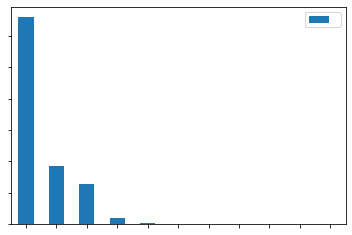

In [858]:
models.print_summary()

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data